# Import Dependencies

In [ ]:
import os
import random
random_state = int(random.random()*1e9)

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

from tensor_completion_models.ETC import ETC
from tensor_completion_models.utils import *

from tensor_completion_models.ensemble_costco import ensemble_costco as EnT

# Data

### Load Data

In [2]:
t = 'log'

In [ ]:
data_folder = 'data/'

In [ ]:
dataset = 'lattice'
# dataset = 'crossed_barrel'
# dataset = 'cogni_spin'

if dataset == 'lattice':
    df = pd.read_csv(f'{data_folder}database_latticedesign.csv')
    features = ['lattice_type', 't', 'uc_x1', 'uc_x2', 'uc_x3']

    targets = [
        'E (MPa)',
        'E_specific (MPa/g)'
        ]

    if len(targets) > 1:
        df_list = list()
        for ti in range(len(targets)): 
            sub_df = df[features + [targets[ti]]].to_numpy()
            sub_df = np.concatenate((ti*np.ones((sub_df.shape[0], 1)), 
                                    sub_df), 
                                    axis = 1)

            df_list.append(sub_df)

        target = 'target'
        df = pd.DataFrame(np.concatenate(df_list), columns = ['task'] + features + [target])
        features = [x for x in list(df.columns) if x != target]
    else:
        target = targets[0]
        df = df[features + [target]]

elif dataset == 'crossed_barrel':
    df = pd.read_csv(f'{data_folder}crossed_barrel_dataset_v2.csv')
    features = ['n', 'theta', 'r', 't']
    targets = ['toughness']
    target = targets[0]
    df = df[features + [target]]
    df = df.groupby(features, as_index=False).agg(target=(target, 'median'))
    target = 'target'

elif dataset.lower() == 'cogni_spin':
    df = pd.read_csv(f'{data_folder}Cogni-e-SpinDB 1.0.csv')

    features = ['solution_concentration', 'voltage_kv', 'flow_rate_ml/h', 'tip_collector_distance_cm',
                'polymer(s)']
    # features += ['needle_diameter_g']  # ~50% missing values!

    target = 'fiber_diameter_nm'

    df = df[df['polymer(s)'].map(lambda x: x in ['PVDF', 'PVA', 'PAN'])]
    codes, uniques = pd.factorize(df["polymer(s)"])
    df['polymer(s)'] = codes

    df = df[features + [target]].dropna()

    mask = (df['flow_rate_ml/h'] < 5) & (df['tip_collector_distance_cm'] < 45) & (df['voltage_kv'] < 40)
    df = df[mask]

In [5]:
df = (
    df.groupby(features, as_index=False)
    .agg(
        value_mean=(target, 'mean'),
        target_std=(target, 'std'),
        target_min=(target, 'min'),
        target_max=(target, 'max'),
        num_duplicates=(target, 'count')
    )
)

df['target_std'] = df['target_std'].fillna(0)
df.columns = [x if x != 'value_mean' else target for x in df.columns]

df = df[df['target_std'] == 0]

df = df[df.columns[:-4]]

# df.sort_values(by='target_std', ascending=False).head(10)

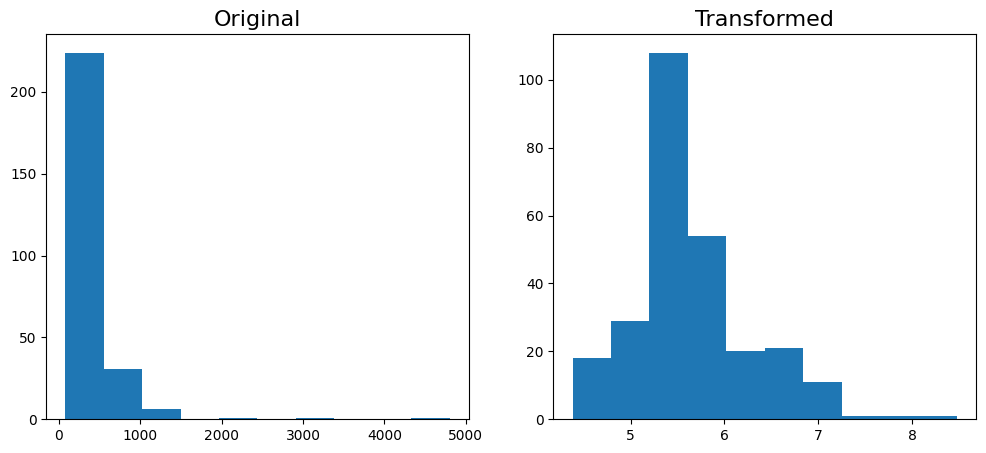

In [6]:
ts = {
    'none': lambda x: x,
    'log': lambda x: np.log(x),
    'sqrt': lambda x: np.sqrt(x),
    'loglog': lambda x: np.log( np.log(x) )
}
t = ts[t.lower()]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df[target])
axes[0].set_title('Original', fontsize = 16)

axes[1].hist(t(df[target]))
axes[1].set_title('Transformed', fontsize = 16)

plt.show()

df[target] = t(df[target])

In [7]:
round_ = None

# round_ = {
#     'default':2.5,
#     'Qtot(uL/min)':25
# }

# round_ = {
#     'Prime Delay':0.5,
#     'Print Speed':1,
#     'X Offset Correction':0.1,
#     'Y Offset Correction':0.1
# }

if type(round_) in [float, int]: round_ = {feature:round_ for feature in features}
elif round_ is not None:
    for feature in features:
        if feature not in round_: round_[feature] = round_['default']
tensor_df = df.copy()
for feature in features:
    if round_ is not None: unique = (tensor_df[feature]//round_[feature]).unique()
    else: unique = tensor_df[feature].unique()
    unique = np.sort(unique)
    conv = {unique[i]:i for i in range(len(unique))}
    if round_ is not None: tensor_df[feature] = (tensor_df[feature]//round_[feature]).map(lambda x: conv[x])
    else: tensor_df[feature] = tensor_df[feature].map(lambda x: conv[x])

tensor_shape = torch.Size([tensor_df[feature].max()+1 for feature in features])
print(tensor_shape)

torch.Size([34, 21, 21, 21, 3])


In [8]:
indices = tensor_df[features].to_numpy()
indices = torch.tensor(indices, dtype = torch.int32)
values = torch.tensor(tensor_df[target].to_numpy())

sparse_tensor = torch.sparse_coo_tensor(indices = indices.t(), 
                                        values = values, 
                                        size = tensor_shape
                                       ).coalesce()

In [9]:
def one_hot_encode(df, col):
    dummies = pd.get_dummies(df[col], prefix=col)
    r_df = pd.concat([dummies.astype(int), df.drop(columns=[col])], axis=1)
    r_df = r_df[[c for c in r_df.columns if c != target] + [target]]
    return r_df

if dataset == 'lattice': df = one_hot_encode(df, 'lattice_type')
features = [x for x in df.columns if x != target]

### Setup Sampling

In [10]:
n_splits = 5

In [11]:
fm = lambda x, y = 6: " "*(y-len(str(x))) + str(x)
for f in [c for c in tensor_df.columns if c != target]: 
    print(f"{fm(f, y = 12 if dataset == 'lattice' else 6)}: {[int(x) for x in list(tensor_df[f].unique())]}")

solution_concentration: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
voltage_kv: [14, 3, 0, 4, 8, 9, 10, 11, 15, 18, 16, 5, 7, 1, 12, 13, 20, 2, 6, 17, 19]
flow_rate_ml/h: [14, 0, 8, 11, 3, 5, 2, 1, 13, 20, 6, 4, 7, 9, 10, 16, 12, 19, 18, 17, 15]
tip_collector_distance_cm: [0, 1, 2, 3, 4, 5, 6, 7, 12, 8, 9, 15, 16, 10, 17, 13, 11, 18, 14, 20, 19]
polymer(s): [0, 1, 2]


In [12]:
if dataset == 'lattice':

    n_in = 50
    n_out_list = [0, 2, 4, 6, 8, 10, 16, 24]
    c1 = 'lattice_type'
    c2 = 't'
    # condition = ((tensor_df[c1] == 0) | (tensor_df[c1] == 1)) & (tensor_df[c2] == 1)

    c1_low, c1_high = 0, 1
    c2_low, c2_high = 1, 1
    condition = (tensor_df[c1] >= c1_low) & (tensor_df[c1] <= c1_high) & (tensor_df[c2] >= c2_low) & (tensor_df[c2] <= c2_high)

if dataset == 'crossed_barrel':

    n_in = 150 
    n_out_list = [25, 50, 75, 100]
    c1 = 'n'
    c2 = 't'
    # condition = (tensor_df[c1] <= 1) & (tensor_df[c2] == 1)

    c1_low, c1_high = 0, 1
    c2_low, c2_high = 1, 2
    condition = (tensor_df[c1] >= c1_low) & (tensor_df[c1] <= c1_high) & (tensor_df[c2] >= c2_low) & (tensor_df[c2] <= c2_high)

if dataset == 'cogni_spin':

    n_in = 75
    n_out_list = [0, 10, 20, 30, 40]
    c1 = 'flow_rate_ml/h'
    c2 = 'voltage_kv'

    c1_low, c1_high = 0, 8
    c2_low, c2_high = 10, 18
    condition = (tensor_df[c1] >= c1_low) & (tensor_df[c1] <= c1_high) & (tensor_df[c2] >= c2_low) & (tensor_df[c2] <= c2_high)


all_train_test_splits = list()
for n_out in n_out_list:
    train_test_splits = list()
    for _ in range(n_splits):

        df1 = df[condition]
        df2 = df[~condition]
        if _ == 0 and n_out == n_out_list[0]: print(df1.shape[0], df2.shape[0])

        df1_i = list(df1.index)
        df2_i = list(df2.index)

        random.shuffle(df1_i)
        random.shuffle(df2_i)

        train_i = df1_i[:n_in]  + df2_i[:n_out]
        test_i = df1_i[n_in:]  + df2_i[n_out:]

        # ________________________________________________________________________________________________________________

        train_df = df.loc[train_i].sample(frac = 1, random_state = random_state)
        test_df = df.loc[test_i].sample(frac = 1, random_state = random_state)
        X_train = train_df[[c for c in train_df.columns if c != target]].to_numpy()
        Y_train = train_df[target].to_numpy()

        X_test = test_df[[c for c in train_df.columns if c != target]].to_numpy()
        Y_test = test_df[target].to_numpy()
        
        X = np.concatenate((X_train, X_test))
        X_train = (X_train - X.min(axis = 0)) / (X.max(axis = 0) - X.min(axis = 0))
        X_test = (X_test - X.min(axis = 0)) / (X.max(axis = 0) - X.min(axis = 0))
        del X

        Y_test = (Y_test - Y_train.min()) / (Y_train.max() - Y_train.min())
        Y_train = (Y_train - Y_train.min()) / (Y_train.max() - Y_train.min())

        # ________________________________________________________________________________________________________________

        tensor_train_df = tensor_df.loc[train_i].sample(frac = 1, random_state = random_state)
        tensor_test_df = tensor_df.loc[test_i].sample(frac = 1, random_state = random_state)

        tensor_features = [c for c in tensor_test_df.columns if c != target]

        tX_train = torch.tensor(tensor_train_df[tensor_features].to_numpy(), dtype = torch.int32).t()
        tX_test = torch.tensor(tensor_test_df[tensor_features].to_numpy(), dtype = torch.int32).t()

        tY_train = torch.tensor(tensor_train_df[target].to_numpy())
        tY_test = torch.tensor(tensor_test_df[target].to_numpy())

        tY_test = (tY_test - tY_train.min()) / (tY_train.max() - tY_train.min())
        tY_train = (tY_train - tY_train.min()) / (tY_train.max() - tY_train.min())

        training_sparse_tensor = torch.sparse_coo_tensor(indices = tX_train,
                                                         values = tY_train, 
                                                         size = tensor_shape
                                                         ).coalesce()

        testing_sparse_tensor = torch.sparse_coo_tensor(indices = tX_test, 
                                                        values = tY_test, 
                                                        size = tensor_shape
                                                        ).coalesce()

        # ________________________________________________________________________________________________________________

        train_test_splits.append({
            'ML':(X_train, X_test, Y_train, Y_test),
            'Tensor':(training_sparse_tensor, testing_sparse_tensor),
            'tensor_test_df':tensor_test_df
        })
        
    all_train_test_splits.append(train_test_splits)

149 115


# Experiments

### Experiment

In [13]:
def get_results():

    all_results = list()
    all_preds = list()

    for tts in range(len(all_train_test_splits)):

        train_test_splits = all_train_test_splits[tts]

        it_list = list()
        pred_it_list = list()

        print(f"Experiment {tts+1}/{len(all_train_test_splits)}")
        print("Iteration:", end = " ")
        for it in range(len(train_test_splits)):

            random_state = int(random.random()*100_000)
            training_sparse_tensor, testing_sparse_tensor = train_test_splits[it]['Tensor']
            X_train, X_test, Y_train, Y_test = train_test_splits[it]['ML']

            metric_list = list()
            pred_list = list()

            # ________________________________________________________________________________________________________________________

            ent = EnT(tensor_shape = tensor_shape,
                    rank = {'lattice':5, 'crossed_barrel':16, 'cogni_spin':16}[dataset],
                    activation = 'relu',
                    dropout = [0.2, 0],
                    hidden_channels = 7,
                    n_decompositions = 10)

            ent.train_model(training_sparse_tensor.indices().t(),
                            training_sparse_tensor.values(),
                            validation_portion = 0,
                            early_stopping = 0,
                            n_epochs = 500, 
                            lr = 5e-3, 
                            wd = 5e-3,
                            print_rate = 100, 
                            verbose = False)

            preds = ent(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
            r2 = r2_score(testing_sparse_tensor.values(), preds)
            mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, testing_sparse_tensor.values()])
            del ent, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            cpd_s = train_tensor_completion(model_type = 'cpd.smooth',
                                            rank = {'lattice':24, 'crossed_barrel':6, 'cogni_spin':4}[dataset],
                                            sparse_tensor = training_sparse_tensor,
                                            non_smooth_modes = {'lattice':[0], 'crossed_barrel':[], 'cogni_spin':[0, 4]}[dataset],
                                            num_epochs = 500,
                                            batch_size = 96,
                                            loss_p = 2,
                                            lr = 1e-3,
                                            wd = 1e-4,
                                            val_size = None,
                                            early_stopping = False,
                                            verbose = False)

            preds = cpd_s(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
            r2 = r2_score(testing_sparse_tensor.values(), preds)
            mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, testing_sparse_tensor.values()])
            del cpd_s, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            model = train_tensor_completion(model_type = 'NeAT',
                                            rank = {'lattice':32, 'crossed_barrel':32, 'cogni_spin':32}[dataset],
                                            sparse_tensor = training_sparse_tensor,
                                            num_epochs = 500,
                                            batch_size = 16,
                                            loss_p = 2,
                                            NeAT_hidden_dim = 32,
                                            NeAT_drop = 0.1,
                                            NeAT_drop2 = 0.5,
                                            val_size = None,
                                            early_stopping = False,
                                            verbose = False)

            preds = model(testing_sparse_tensor.indices().t()).detach().cpu().numpy()
            r2 = r2_score(testing_sparse_tensor.values(), preds)
            mae = abs(preds - testing_sparse_tensor.values().numpy()).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, testing_sparse_tensor.values()])
            del model, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            xgb = XGBRegressor(n_estimators = 100,
                            max_depth = None,
                            random_state = random_state)

            xgb.fit(X_train, Y_train)
            preds = xgb.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, Y_test])
            del xgb, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            catb = CatBoostRegressor(iterations = 500,
                                     learning_rate = 5e-2,
                                     depth = 16,
                                     loss_function = 'RMSE',
                                     random_state = random_state,
                                     verbose = False)

            catb.fit(X_train, Y_train)
            preds = catb.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, Y_test])
            del catb, preds, r2, mae           

            # ________________________________________________________________________________________________________________________

            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(1e-3, (1e-5, 1e1))
            gp = GaussianProcessRegressor(kernel = kernel, 
                                        alpha = 1e-6, 
                                        n_restarts_optimizer = 5, 
                                        random_state = random_state)

            gp.fit(X_train, Y_train)
            preds = gp.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, Y_test])
            del gp, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            rf = RandomForestRegressor(n_estimators = 100, 
                                    max_depth = None, 
                                    random_state = random_state)

            rf.fit(X_train, Y_train)
            preds = rf.predict(X_test)
            r2 = r2_score(Y_test, preds)
            mae = abs(preds - Y_test).mean()
            metric_list.append([r2, mae])
            pred_list.append([preds, Y_test])
            del rf, preds, r2, mae

            # ________________________________________________________________________________________________________________________

            it_list.append(metric_list)
            pred_it_list.append(pred_list)

            if it == len(train_test_splits)-1: print(it+1, '\n')
            else: print(it+1, end = ", ")

        all_results.append(it_list)
        all_preds.append(pred_it_list)

    all_results = np.stack(all_results)
    print("All done!")

    return all_results, all_preds

### Display Progress

In [14]:
results, preds = get_results()

Experiment 1/5
Iteration: 1, 2, 3, 4, 5 

Experiment 2/5
Iteration: 1, 2, 3, 4, 5 

Experiment 3/5
Iteration: 1, 2, 3, 4, 5 

Experiment 4/5
Iteration: 1, 2, 3, 4, 5 

Experiment 5/5
Iteration: 1, 2, 3, 4, 5 

All done!


# Results

In [20]:
models_colors = {
    'CoSTCo':'limegreen',
    'CPD-S':'deepskyblue',
    'NeAT':'darkorange',
    'XGBoost':'black',
    'CatBoost':'red',
    'Gaussian Process':'slategray',
    'Random Forest':'saddlebrown'
    }

models = list(models_colors)
colors = list(models_colors.values())

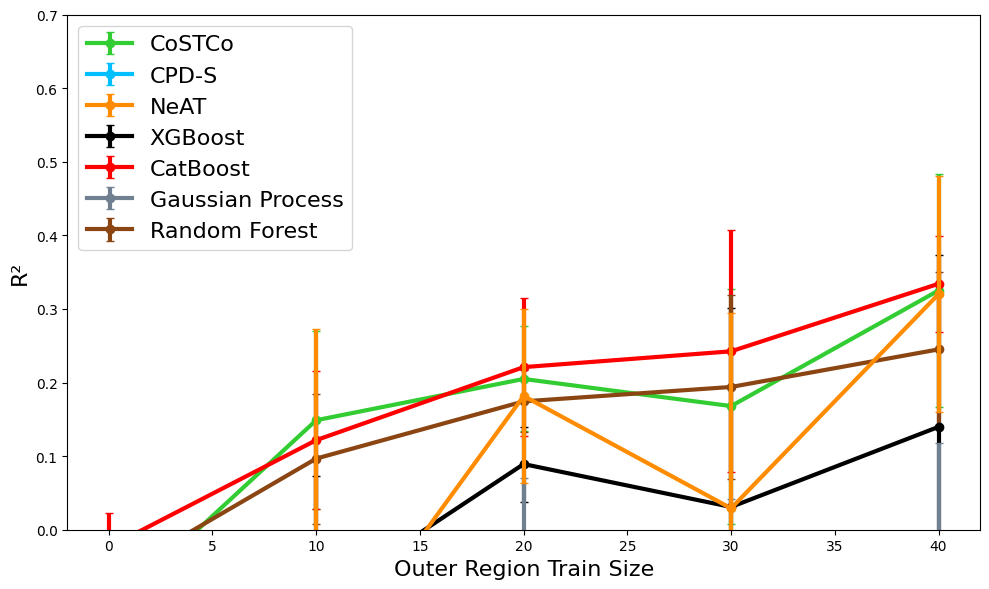

In [21]:
mean_metrics = results[..., 0].mean(axis=1)
std_metrics  = results[..., 0].std(axis=1)

plt.figure(figsize=(10, 6))

# for i in reversed(range(len(models))):
for i in range(len(models)):
    if models[i].lower() in ['neatd']: continue
    plt.errorbar(
        n_out_list,
        mean_metrics[:, i],
        yerr = std_metrics[:, i],
        lw = 3,
        marker='o',
        capsize=3,
        label=models[i],
        color = colors[i],
        zorder = 1 if models[i].lower() == 'neat' else 0
    )

plt.xlabel("Outer Region Train Size", fontsize = 16)
plt.ylabel("R²", fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(False)

if dataset == 'lattice': plt.ylim(0.5, 1)
if dataset == 'cogni_spin': plt.ylim(0, 0.7)
else: plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [22]:
all_mets = list()
for train_i in range(len(preds)):
    it_mets = list()
    for it_i in range(n_splits):
        model_mets = list()
        for model_i in range(len(preds[0][0])):
            yh, y = preds[train_i][it_i][model_i]

            if type(yh) == torch.Tensor: yh = yh.numpy()
            if type(y) == torch.Tensor: y = y.numpy()

            training_sparse_tensor, testing_sparse_tensor = all_train_test_splits[train_i][it_i]['Tensor']
            X_train, X_test, Y_train, Y_test = all_train_test_splits[train_i][it_i]['ML']
            tensor_test_df = all_train_test_splits[train_i][it_i]['tensor_test_df']
            test_ood_idx = [x in df2.index for x in tensor_test_df.index]

            ood_yh, ood_y = (yh[test_ood_idx], y[test_ood_idx])

            r2 = r2_score(ood_y, ood_yh)
            mae = abs(ood_y - ood_yh).mean()
            mape = abs((ood_y - ood_yh) / ood_y).mean()
            model_mets.append([r2, mae, mape])
        it_mets.append(model_mets)
    all_mets.append(it_mets)
all_mets = np.stack(all_mets)

/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_59404/1559933969.py:21: RuntimeWarning: divide by zero encountered in divide
  mape = abs((ood_y - ood_yh) / ood_y).mean()
/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_59404/1559933969.py:21: RuntimeWarning: divide by zero encountered in divide
  mape = abs((ood_y - ood_yh) / ood_y).mean()
/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_59404/1559933969.py:21: RuntimeWarning: divide by zero encountered in divide
  mape = abs((ood_y - ood_yh) / ood_y).mean()
/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_59404/1559933969.py:21: RuntimeWarning: divide by zero encountered in divide
  mape = abs((ood_y - ood_yh) / ood_y).mean()
/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_59404/1559933969.py:21: RuntimeWarning: divide by zero encountered in divide
  mape = abs((ood_y - ood_yh) / ood_y).mean()
/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_59404/1559933969.py:21: Runtime

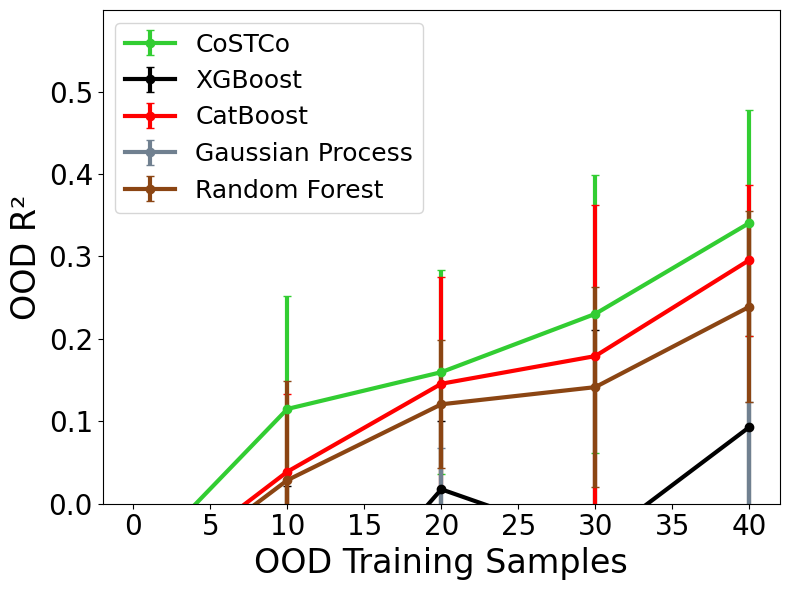

In [ ]:
metric = 0
mean_metrics = all_mets[..., metric].mean(axis=1)
std_metrics  = all_mets[..., metric].std(axis=1)

begin_n = 0
end_n = len(n_out_list)

# end_n = 6

plt.figure(figsize=(8, 6))

# for i in reversed(range(len(models))):
for i in range(len(models)):
    if models[i].lower() in ['cpd-s', 'neat']: continue
    plt.errorbar(
        n_out_list[begin_n:end_n],
        mean_metrics[begin_n:end_n, i],
        yerr = std_metrics[begin_n:end_n, i],
        lw = 3,
        marker = 'o',
        capsize = 3,
        label = models[i],
        color = colors[i],
        zorder = 1 if models[i].lower() == 'neat' else 0
    )

plt.xlabel("OOD Training Samples", fontsize = 24)
plt.ylabel("OOD " + ["R²", "MAE"][metric], fontsize = 24)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.legend(fontsize = 18)
plt.grid(False)

# plt.ylim(bottom = 0.5, top = 1)
# plt.ylim(0.25, 1)

plt.ylim(bottom = 0)

plt.tight_layout()
plt.show()